# Santador Customer Transaction Prediction 데이터 분석

## 1. EDA, 피처 엔지니어링 (변수 선택 및 스케일링 등)
커널 참고: https://www.kaggle.com/kernels/scriptcontent/12442041/download

In [2]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

## Load data

In [3]:
PATH='./data/'
os.listdir(PATH)

['sample_submission.csv', 'test.csv', 'train.csv']

Let's load the train and test data files.

In [4]:
%%time
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

Wall time: 17.1 s


# Data exploration

In [5]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

In [6]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


Train 데이터 구성:  

* **ID_code** (string);  
* **target**;  
* **200** numerical variables, named from **var_0** to **var_199**;

Test 데이터 구성:  

* **ID_code** (string);  
* **200** numerical variables, named from **var_0** to **var_199**;

결측치와 자료형을 확인합니다.

In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
%%time
missing_data(train_df)

Wall time: 991 ms


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


테스트 데이터셋 확인

In [10]:
%%time
missing_data(test_df)

Wall time: 893 ms


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


트레인 데이터와 테스트 데이터 모두에 결측치는 존재하지 않는다. 수치형 변수를 확인해본다.

In [11]:
%%time
train_df.describe()

Wall time: 2.64 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [12]:
%time
test_df.describe()

Wall time: 0 ns


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


* 표준 편차는 트레인 및 테스트 변수 데이터 모두에 대해 상대적으로 크다.
* 트레인 및 테스트 데이터에 대한 최소, 최대, 평균, sdt 값이 매우 비슷해 보인다.
* 평균값은 넓은 범위에 분포된다.

트레인, 테스트 셋의 값 크기는 동일하다. 일부 피처에 대한 산점도를 그린다.

In [13]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

데이터의 5%만 확인한다. (x축 트레인, y축 테스트)

<Figure size 432x288 with 0 Axes>

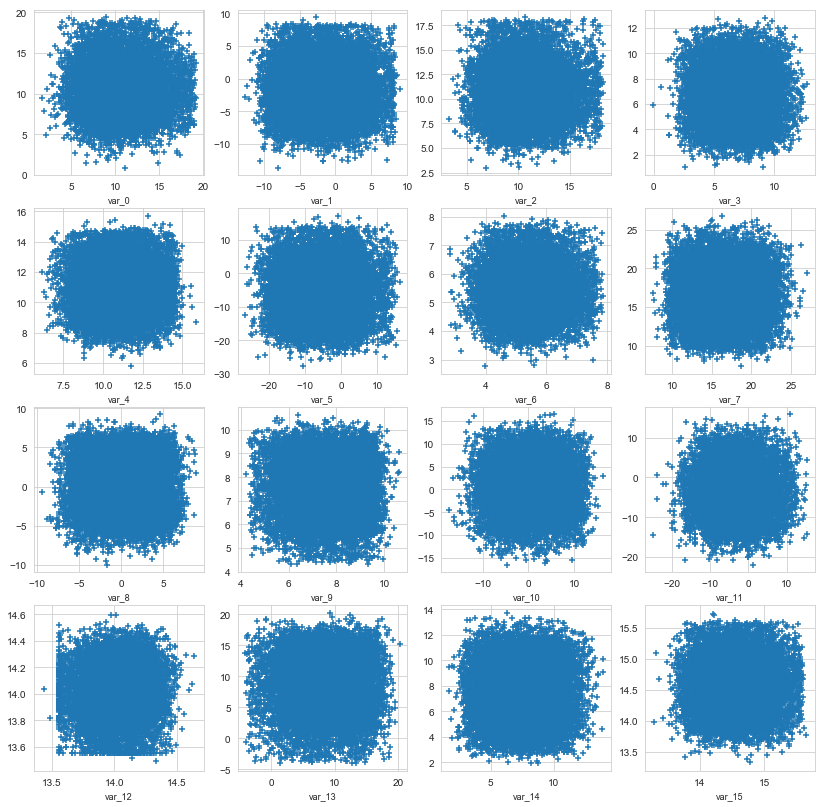

In [14]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

트레인셋의 **타깃** 값 분포 확인

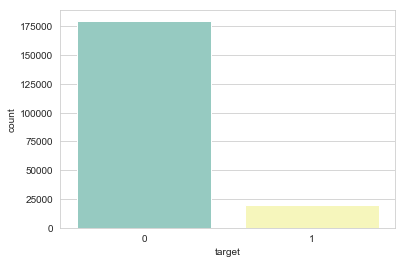

In [15]:
sns.countplot(train_df['target'], palette='Set3')

In [16]:
print(" {}% 의 값이 1인 타깃 값이 있다 ".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

 10.049% 의 값이 1인 타깃 값이 있다 


**타깃** 값의 관점에서 볼 때 밸런스가 맞지 않고 있다.  

## 피처 상관 관계

가장 관련성이 적은 10개의 피처를 뽑아 본다

In [17]:
%%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

Wall time: 263 ms


동일한 쌍 외에 가장 관련성이 높은 피처들을 뽑아 본다

In [18]:
correlations.tail(10)

,level_0,level_1,0
230,var_3,var_13,0.005717
231,var_13,var_3,0.005717
232,var_9,var_15,0.006054
233,var_15,var_9,0.006054
234,var_2,var_0,0.006573
235,var_0,var_2,0.006573
236,var_0,var_6,0.006983
237,var_6,var_0,0.006983
238,var_13,var_2,0.008795
239,var_2,var_13,0.008795


관련성이 낮은 피처들을 뽑아 본다. 확인해보면 피처간 상관관계가 상당히 작음을 알 수 있다.

In [19]:
correlations.head(10)

,level_0,level_1,0
0,var_1,var_3,0.000010
1,var_3,var_1,0.000010
2,var_15,var_0,0.000043
3,var_0,var_15,0.000043
4,var_6,var_4,0.000049
5,var_4,var_6,0.000049
6,var_13,var_15,0.000109
7,var_15,var_13,0.000109
8,var_13,var_9,0.000119
9,var_9,var_13,0.000119


## 중복값 확인

In [20]:
%%time
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Wall time: 9.65 s


트레인 셋의 중복값 (최대 15개)

In [21]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


테스트 셋의 중복값 (최대 15개)

In [22]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


트레인 및 테스트 셋의 동일한 열에는 동일하거나 매우 가까운 값의 동일하거나 매우 가까운 수의 복제본이 있다.

In [23]:
print('트레인, 테스트 칼럼 수: {} {}'.format(len(train_df.columns), len(test_df.columns)))

트레인, 테스트 칼럼 수: 202 201


SVM의 적용을 위해 데이터 개수를 조정

In [26]:
from sklearn.model_selection import train_test_split

train_df_reduced = train_df.sample(n=10000)
X = train_df_reduced.drop(['ID_code'], axis=1)
y = train_df_reduced['target']
tr, td, y_tr, y_td = train_test_split(X, y, test_size=0.4, random_state=0)

In [27]:
X.shape

(10000, 201)

In [28]:
y_tr = y_tr.values
y_td = y_td.values

## 2. PCA 적용하여 차원 축소

데이터 정규화

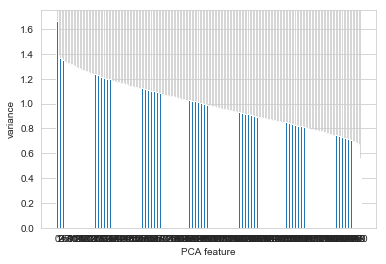

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# pipeline? 시스템의 효율을 높이기 위해 명령문을 수행하면서 몇 가지의 특수한 작업들을 병렬 처리하도록 설계됨

scaler = StandardScaler()
pca = PCA() # pca , 디폴트 components는 n(전체 feature 수)
pipeline = make_pipeline(scaler,pca)

pipeline.fit(tr) # pipeline의 fit = 내장 전처리함수의 fit_transform 호출
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance') #고유값
plt.xticks(features)
plt.show()

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

model = PCA()
pca_features = model.fit_transform(tr)

pc1 = pca_features[:,0] # ↑
pc2 = pca_features[:,1]
pc3 = pca_features[:,2]

In [31]:
model_t = PCA(n_components=10)
pca_features_t = model.fit_transform(tr)

## 3. SVM 학습 및 하이퍼 파라미터 튜닝

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

In [33]:
model.fit(tr)
t_tr = pca.transform(tr)
t_td = pca.transform(td)
clf = SVC(kernel='linear')
clf.fit(t_tr, y_tr)
print ('score', clf.score(t_td, y_td))
print ('pred label', clf.predict(t_td))

score 1.0
pred label [0 0 0 ... 0 0 0]


In [34]:
model_t.fit(tr)
t_tr = pca.transform(tr)
t_td = pca.transform(td)
clf = SVC(kernel='linear')
clf.fit(t_tr, y_tr)
print ('score', clf.score(t_td, y_td))
print ('pred label', clf.predict(t_td))

score 1.0
pred label [0 0 0 ... 0 0 0]


하이퍼 파라미터 튜닝

In [35]:
svm_model= SVC()

tuned_parameters = {
 'C': [0.1,0.5,1.0] , 'kernel': ['linear'],
 'C': [0.1,0.5,1.0] , 'gamma': [0.01,0.03,0.05], 'kernel': ['rbf']
                   }

In [36]:
from sklearn.model_selection import GridSearchCV

model_svm = GridSearchCV(svm_model, tuned_parameters,cv=10,scoring='accuracy')

In [37]:
model_svm.fit(tr, y_tr)
print(model_svm.best_score_)

0.8975


In [38]:
print(model_svm.best_params_) #제일 좋은 결과 뽑기

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


In [42]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc= SVC(C=0.1, gamma=0.01, kernel='rbf')
svc.fit(tr, y_tr)
y_pred=svc.predict(td)
print('Accuracy Score:')
print(accuracy_score(y_td,y_pred))

Accuracy Score:
0.89925
